In [1]:
from __future__ import print_function

import math
import numpy as np
import pandas as pd
import json
import random
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image

from collections import Counter

/root/notebooks/anaconda3/envs/clip/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from itertools import product

import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import (CenterCrop, Compose, InterpolationMode,
                                    Normalize, RandomHorizontalFlip,
                                    RandomPerspective, RandomRotation, Resize,
                                    ToTensor)
from torchvision.transforms.transforms import RandomResizedCrop
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader

BICUBIC = InterpolationMode.BICUBIC
from model.dfsp import DFSP
from parameters import parser, YML_PATH
from utils import *


seed = 1

In [3]:
from model.common import *
from test import *
from test import test
from tqdm import tqdm
import heapq

In [4]:
from dataset import CompositionDataset

In [5]:
dataset_path = '../OADis/OADis/path/to/mitstates'

In [6]:
train_dataset = CompositionDataset(dataset_path,
                                   phase='train',
                                   split='compositional-split-natural')

val_dataset = CompositionDataset(dataset_path,
                                 phase='val',
                                 split='compositional-split-natural')

# test_dataset = CompositionDataset(dataset_path,
#                                    phase='test',
#                                    split='compositional-split-natural',
#                                  open_world=True)

# train pairs: 1262 | # val pairs: 600 | # test pairs: 800
# train images: 30338 | # val images: 10420 | # test images: 12995
# train pairs: 1262 | # val pairs: 600 | # test pairs: 800
# train images: 30338 | # val images: 10420 | # test images: 12995


In [7]:
str(len(train_dataset.pairs))

'1962'

In [8]:
batch = train_dataset.__getitem__(0)

### Âª∫Á´ã DFSP

In [9]:
allattrs = train_dataset.attrs
allobj = train_dataset.objs
classes = [cla.replace(".", " ").lower() for cla in allobj]
attributes = [attr.replace(".", " ").lower() for attr in allattrs]
offset = len(attributes)

In [10]:
class config():
    def __init__(self):
        self.K=1 
        self.SA_K=1
        self.att_obj_w=0.01
        self.attr_dropout=0.3
        self.best_model_metric='best_unseen'
        self.bias=0.001
        self.clip_model='ViT-L/14'
        self.context_length=8
        self.dataset='mit-states'
        self.dataset_path='../OADis/OADis/path/to/mitstates'
        self.epoch_start=0
        self.epochs=20
        self.eval_batch_size=256
        self.fusion='txt2img'
        self.gradient_accumulation_steps=2
        self.load_model='data/model/mit-states/dfsp/txt2img_best.pt'
        self.lr=0.0001
        self.open_world=True
        self.prompt_template='a photo of x x'
        self.res_w=0.8
        self.save_every_n=5
        self.save_model=False
        self.save_path='data/model/mit-states/dfsp'
        self.seed=0
        self.sp_w=0.1
        self.text_encoder_batch_size=36
        self.threshold=0.4
        self.threshold_trials=50
        self.topk=1
        self.train_batch_size=128
        self.weight_decay=1e-05
        self.width_img=1024
        self.width_txt=768

In [12]:
con=config()

### Âª∫Á´ãDFSP model

In [13]:
DFSP_model = DFSP(con, attributes=attributes, classes=classes, offset=offset).cuda()
# DFSP_model.load_state_dict(torch.load('data/model/mit-states/dfsp/txt2img_best.pt'))

### Âª∫Á´ãall_fv_proj_idx

In [16]:
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
attr2idx = train_dataset.attr2idx
obj2idx = train_dataset.obj2idx

train_pairs = torch.tensor([(attr2idx[attr], obj2idx[obj])
                            for attr, obj in train_dataset.train_pairs]).cuda()

In [17]:
all_fv_proj_idx = []
for i in range(245):
    fv_proj_idx = 0
    fv_proj_idx = torch.Tensor().cuda()
    for obj_idx in range(len(train_pairs)):
        if train_pairs[obj_idx][1] ==i:
            fv_proj_idx = torch.cat([fv_proj_idx, train_pairs[obj_idx]], dim=0)
    fv_proj_idx=fv_proj_idx.reshape(-1,2)
    all_fv_proj_idx.append(fv_proj_idx)


In [23]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

DFSP_model.train()
best_loss = 1e5
best_metric = 0



train_losses = []
k=0
for i in range(con.epoch_start, con.epochs):
#     progress_bar = tqdm.tqdm(
#         total=len(train_dataloader), desc="epoch % 3d" % (i + 1)
#     )

    epoch_train_losses = []
    for bid, batch in enumerate(train_dataloader):

        batch_img = batch[0].cuda()
#             predict = model(batch_img, train_pairs)
        predict = DFSP_model(batch_img, train_pairs,True,batch[2],all_fv_proj_idx=all_fv_proj_idx)  ###Êõ¥ÊîπÊâπÈáèË®àÁÆó
        k=k+1
        if k ==2:
            break
    if k ==2:
            break

2555
2555


In [26]:
predict[4].size()

torch.Size([8, 115])

### ÈñãÂßãÈ†êÊ∏¨

In [15]:
def predict_logits(model, dataset, config,all_fv_proj_idx):
    """Function to predict the cosine similarities between the
    images and the attribute-object representations. The function
    also returns the ground truth for attributes, objects, and pair
    of attribute-objects.

    Args:
        model (nn.Module): the model
        text_rep (nn.Tensor): the attribute-object representations.
        dataset (CompositionDataset): the composition dataset (validation/test)
        device (str): the device (either cpu/cuda:0)
        config (argparse.ArgumentParser): config/args

    Returns:
        tuple: the logits, attribute labels, object labels,
            pair attribute-object labels
    """
    model.eval()
    all_attr_gt, all_obj_gt, all_pair_gt = (
        [],
        [],
        [],
    )
    all_img_path = []
    
    attr2idx = dataset.attr2idx
    obj2idx = dataset.obj2idx
    # print(text_rep.shape)
    pairs_dataset = dataset.pairs
    pairs = torch.tensor([(attr2idx[attr], obj2idx[obj])
                                for attr, obj in pairs_dataset]).cuda()
    dataloader = DataLoader(
        dataset,
        batch_size= 128,
        shuffle=False)
    all_logits = torch.Tensor()
    loss = 0
    all_logits_attr_org = torch.Tensor()
    all_logits_attr_our = torch.Tensor()
#     all_fv_proj_idx =construct_all_fv_proj_idx(dataset,pairs)
    i = 0
    with torch.no_grad():
        for idx, data in tqdm(
            enumerate(dataloader), total=len(dataloader), desc="Testing"
        ):
            batch_img = data[0].cuda()
#             predict = model(batch_img, pairs)
#             predict = model(batch_img, pairs,True,data[2][0],all_fv_proj_idx=all_fv_proj_idx) ##ÈÄôÂÄãÊòØ‰∏ÄÂºµ‰∏ÄÂºµÁÆó
            predict = model(batch_img, pairs,True,data[2],all_fv_proj_idx=all_fv_proj_idx)  ###Êõ¥ÊîπÊâπÈáèË®àÁÆó
            logits = predict[0]
#             loss += loss_calu(predict, data, config)
            attr_truth, obj_truth, pair_truth = data[1], data[2], data[3]
            logits = logits.cpu()
            #------------------------------
            logits_attr_org,logits_attr_our= predict[1].cpu(),predict[4].cpu()
            all_logits_attr_org = torch.cat([all_logits_attr_org, logits_attr_org], dim=0)
            all_logits_attr_our = torch.cat([all_logits_attr_our, logits_attr_our], dim=0)
            logits_attrs_list = [all_logits_attr_org,all_logits_attr_our]
            #------------------------------
            all_logits = torch.cat([all_logits, logits], dim=0)
            all_attr_gt.append(attr_truth)
            all_obj_gt.append(obj_truth)
            all_pair_gt.append(pair_truth)
            all_img_path = all_img_path + list(data[4])
            i = i +1
#             if i == 2:
#                 break

    all_attr_gt, all_obj_gt, all_pair_gt = (
        torch.cat(all_attr_gt).to("cpu"),
        torch.cat(all_obj_gt).to("cpu"),
        torch.cat(all_pair_gt).to("cpu"),
    )

    return all_logits, all_attr_gt, all_obj_gt, all_pair_gt,logits_attrs_list,all_img_path

In [16]:
def test(
        test_dataset,
        logits_attrs_list, ###Êñ∞Â¢û
        evaluator,
        all_logits,
        all_attr_gt,
        all_obj_gt,
        all_pair_gt,
        config):
    ###----------------Êñ∞Â¢ûÈ†êÊ∏¨att--------------
    attr2idx = test_dataset.attr2idx
    obj2idx = test_dataset.obj2idx
    pairs_dataset = test_dataset.pairs
    pairs = torch.tensor([(attr2idx[attr], obj2idx[obj])
                                for attr, obj in pairs_dataset]).cuda()
    #-----------------------------------------
    att_ped_org = torch.argmax(logits_attrs_list[0],dim=1)
    att_ped_our = torch.argmax(logits_attrs_list[1],dim=1)
    ###---------------------------------------
    predictions = {
        pair_name: all_logits[:, i]
        for i, pair_name in enumerate(test_dataset.pairs)
    }
    all_pred = [predictions]

    all_pred_dict = {}
    for k in all_pred[0].keys():
        all_pred_dict[k] = torch.cat(
            [all_pred[i][k] for i in range(len(all_pred))]
        ).float()

    results = evaluator.score_model(
        all_pred_dict, all_obj_gt, bias=1e3, topk=1
    )


    attr_acc_ep1 = float(torch.mean(
        (results['unbiased_closed'][0].squeeze(-1) == all_attr_gt).float()))   ##ÂÖàË®àÁÆóÂéüÊú¨ÁöÑattr Âíåobj acc
    obj_acc = float(torch.mean(
        (results['unbiased_closed'][1].squeeze(-1) == all_obj_gt).float()))
        ###----------------Êñ∞Â¢ûÈ†êÊ∏¨att--------------    
    results['unbiased_closed_our'] = (att_ped_our).unsqueeze(1).clone(),results['unbiased_closed'][1]

    attr_acc_ep2 = float(torch.mean(
        (results['unbiased_closed_our'][0].squeeze(-1) == all_attr_gt).float()))
        ###----------------Êñ∞Â¢ûÈ†êÊ∏¨att--------------
        ###----‰ΩøÁî®Á∞°ÂñÆÂ≠∏Áøí-----------
    b,n_attr =  logits_attrs_list[1].size()
    final_pred = torch.zeros(b, dtype=torch.long)
    pred_ep1,pred_ep2 = results['unbiased_closed'][0].squeeze(-1).float(), logits_attrs_list[1].argmax(dim=1).float() 

    votes = torch.stack([pred_ep1, pred_ep2], dim=0)
    majority_vote, _ = torch.mode(votes, dim=0)
    correct_majority_vote = (majority_vote == all_attr_gt).sum().item()
    attr_acc_sim_vote = correct_majority_vote / b
    
    ####ÈõÜÊàêÂ≠∏Áøí
    for i in range(b):
        if pred_ep1[i] == pred_ep2[i]:
            final_pred[i] = pred_ep1[i]
        else:
            final_pred[i] = pred_ep1[i] if attr_acc_ep1 > attr_acc_ep2 else pred_ep2[i]

    # ËÆ°ÁÆóÊäïÁ•®ÂêéÁöÑÂáÜÁ°ÆÁéá
    attr_acc_vote = (final_pred == all_attr_gt).sum().item() / b

    stats = evaluator.evaluate_predictions(
        results,
        all_attr_gt,
        all_obj_gt,
        all_pair_gt,
        all_pred_dict,
        topk=1,
    )
###----------------Êñ∞Â¢ûÈ†êÊ∏¨att--------------
    stats['attr_acc_ep2'] = attr_acc_ep2
#     stats['attr_acc_ep1'] = attr_acc_ep1 
    stats['attr_acc_vote'] = attr_acc_vote
    stats['attr_acc_sim_vote'] = attr_acc_sim_vote
###----------------Êñ∞Â¢ûÈ†êÊ∏¨att--------------
    stats['attr_acc_ep1'] = attr_acc_ep1
    stats['obj_acc'] = obj_acc   ###ÂéüÊú¨Ë´ñÊñá‰∏≠ÁöÑacc


    return stats

In [17]:
print('evaluating on the test set')
with torch.no_grad():
    evaluator = Evaluator(test_dataset, model=None)
    all_logits, all_attr_gt, all_obj_gt, all_pair_gt, logits_attrs_list,all_img_path = predict_logits(
        DFSP_model, test_dataset, con,all_fv_proj_idx)

evaluating on the test set
Evaluating with test pairs


Testing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 102/102 [24:32<00:00, 14.44s/it]


In [18]:
feasibility_path = os.path.join(
    DIR_PATH, f'data/feasibility_{con.dataset}.pt')
unseen_scores = torch.load(
    feasibility_path,
    map_location='cpu')['feasibility']
seen_mask = val_dataset.seen_mask.to('cpu')
min_feasibility = (unseen_scores + seen_mask * 10.).min()
max_feasibility = (unseen_scores - seen_mask * 10.).max()
thresholds = np.linspace(
    min_feasibility,
    max_feasibility,
    num=con.threshold_trials)
best_auc = 0.
best_th = 0.4
val_stats = None
if con.open_world and best_th is not None:
    print('using threshold: ', best_th)
    temp_all_logits = threshold_with_feasibility(
        all_logits,
        test_dataset.seen_mask,
        threshold=best_th,
        feasiblity=unseen_scores)


using threshold:  0.4


### Ë∑ëË∑ëÁúãtest fun

In [19]:
test_stats = test(
    test_dataset,
    logits_attrs_list,   ###Êñ∞Â¢û
    evaluator,
    temp_all_logits,
    all_attr_gt,
    all_obj_gt,
    all_pair_gt,
    con
)

result = ""
for key in test_stats:
    result = result + key + "  " + \
        str(round(test_stats[key], 4)) + "| "
print(result)

closed_attr_match  0.2493| closed_obj_match  0.4893| closed_match  0.1507| closed_seen_match  0.0| closed_unseen_match  0.1845| closed_ca  2.0| closed_seen_ca  1.0| closed_unseen_ca  1.0| closed_ub_attr_match  0.2977| closed_ub_obj_match  0.5095| closed_ub_match  0.1637| closed_ub_seen_match  0.3761| closed_ub_unseen_match  0.1161| closed_ub_ca  2.0| closed_ub_seen_ca  1.0| closed_ub_unseen_ca  1.0| biasterm  0.9999| best_unseen  0.1845| best_seen  0.4828| AUC  0.0707| hm_unseen  0.1552| hm_seen  0.2786| best_hm  0.1993| attr_acc_ep2  0.2759| attr_acc_vote  0.2977| attr_acc_sim_vote  0.2893| attr_acc_ep1  0.2977| obj_acc  0.5095| 


### ÊâæÂ∞ãÂâç5Â§ßÁöÑÂÄº

In [20]:
# def pred(pairs,all_logits):      ###ÂñÆÁ¥îÁÖßÊäÑtest‰∏≠ÁöÑ‰∏Ä‰∫õÊìç‰Ωú Â∞áall_logit >all_pred_dict
#     predictions = {
#         pair_name: all_logits[:, i]
#         for i, pair_name in enumerate(pairs)
#     }
#     all_pred = [predictions]

#     all_pred_dict = {}
#     for k in all_pred[0].keys():
#         all_pred_dict[k] = torch.cat(
#             [all_pred[i][k] for i in range(len(all_pred))]
#         ).float()
#     return all_pred_dict

# def find_pair_pred(idx,obj_gt,pairs):
#     for i in range(len(idx)):
#         tensor_to_find = torch.tensor([idx[i], obj_gt], device='cuda:0')
#         #print(i)
#         for j in range(pairs.shape[0]):
#             if torch.equal(pairs[j], tensor_to_find):    ###Ë®àÁÆóÊâÄÊúâÁöÑpairs‰∏≠ ÊúâÊ≤íÊúâË¶ÅÂ∞ãÊâæÁöÑpairs
#                 #print(f"Index found at pair[{j}]")
#                 return j
# def find_max5(row_nub,values_list):   ####Âú®logitÁîüÊàêÁöÑlist‰∏≠ÊâæÂà∞ÂâçÂàÜÊï∏ÊúÄÂ§ßÁöÑÂâçÂπæÂÄã
#     max_k_list = []
#     for nub in range(row_nub):
#         column = [x[nub].item() for x in values_list]  
#         #print(column)
#         #top_5 = sorted(column, reverse=True)[:20]  ###Ê¢ù20Â∞±ÊòØÂâç20Â§ß
#         top_5 = sorted(column, reverse=True)[:]  ###Ê¢ù20Â∞±ÊòØÂâç20Â§ß
#         #print(top_5)
#         max_k_list.append(top_5)
#     return max_k_list

# def cal_pred(max_k_list,values_list,all_obj_gt,pairs):
#     pred_list = []
#     for batch_img in range(len(max_k_list)):
#         left_column = [x[batch_img].item() for x in values_list]
#         Max_idx = []    #ÊâæÂá∫Â∞çÊáâmax_k_list Âú®values_listÂ∞çÊáâÁöÑMax_idx
#         for value in max_k_list[batch_img]:
#             index = left_column.index(value)
#             Max_idx.append(index)
#         #print(Max_idx)   ### idxÊáâË©≤Ë¶ÅÊòØÂú®values_listÂ∞çÊáâÁöÑidx
#         pred = find_pair_pred(Max_idx,all_obj_gt[batch_img],pairs)
#         pred_list.append(pred)
#     return pred_list

### ÂéüÊú¨‰ΩøÁî®ÊñπÊ≥ï

In [21]:
# def logits_attrs_cal(test_dataset,pairs,logits_attrs,all_fv_proj_idx,all_obj_gt):###Ë®àÁÆólogits_attrs_list[0]Âíå[1]ÁöÑped
#     all_fv_proj_idx =construct_all_fv_proj_idx(test_dataset,pairs)
#     attr_pred= pred(test_dataset.attrs,logits_attrs)
#     values_list = list(attr_pred.values())
#     max_k_list = find_max5(values_list[0].size()[0],values_list)   ###ÊâæÂà∞ÊúÄÂ§ßÁöÑ‰∏¶ÊéíÂ∫è
#     pred_list = cal_pred(max_k_list,values_list,all_obj_gt,pairs)   ###Ë®àÁÆóÈ†êÊ∏¨
#     att_ped = [x[0].item() for x in pairs[pred_list]]        ###ÂæóÂà∞È†êÊ∏¨
#     obj_ped = [x[1].item() for x in pairs[pred_list]]
#     return att_ped,obj_ped
# att_ped_org,obj_ped_org = logits_attrs_cal(test_dataset,pairs,logits_attrs_list[0],all_fv_proj_idx,all_obj_gt)
# att_ped_our,obj_ped_our = logits_attrs_cal(test_dataset,pairs,logits_attrs_list[1],all_fv_proj_idx,all_obj_gt)

In [22]:
predictions = {
    pair_name: temp_all_logits[:, i]
    for i, pair_name in enumerate(test_dataset.pairs)
}
all_pred = [predictions]

all_pred_dict = {}
for k in all_pred[0].keys():
    all_pred_dict[k] = torch.cat(
        [all_pred[i][k] for i in range(len(all_pred))]
    ).float()

results = evaluator.score_model(
    all_pred_dict, all_obj_gt, bias=1e3, topk=1
)

### Âú®test‰∏≠Êõ¥ÊîπËº∏Âá∫accÁöÑÈÉ®ÂàÜ

In [23]:
# att_ped_org = torch.argmax(logits_attrs_list[0],dim=1)
# att_ped_our = torch.argmax(logits_attrs_list[1],dim=1)
# results['unbiased_closed'] = (att_ped_org).unsqueeze(1).clone(),results['unbiased_closed'][1]
# results['unbiased_closed_our'] = (att_ped_our).unsqueeze(1).clone(),results['unbiased_closed'][1]

# attr_acc_our = float(torch.mean(
#     (results['unbiased_closed_our'][0].squeeze(-1) == all_attr_gt).float()))
# obj_acc_our = float(torch.mean(
#     (results['unbiased_closed_our'][1].squeeze(-1) == all_obj_gt).float()))    

# attr_and_obj_acc_our = (torch.sum(
#     (results['unbiased_closed_our'][0].squeeze(-1) == all_attr_gt) & 
#     (results['unbiased_closed_our'][1].squeeze(-1) == all_obj_gt)).float() / 
#     float(all_attr_gt.shape[0]))

# attr_acc = float(torch.mean(
#     (results['unbiased_closed'][0].squeeze(-1) == all_attr_gt).float()))
# obj_acc = float(torch.mean(
#     (results['unbiased_closed'][1].squeeze(-1) == all_obj_gt).float()))

# stats = evaluator.evaluate_predictions(
#     results,
#     all_attr_gt,
#     all_obj_gt,
#     all_pair_gt,
#     all_pred_dict,
#     topk=1,
# )


# stats['attr_acc_our'] = attr_acc_our
# stats['obj_acc_our'] = obj_acc_our
# ###----------------Êñ∞Â¢ûÈ†êÊ∏¨att--------------
# stats['attr_acc'] = attr_acc
# stats['obj_acc'] = obj_acc

# print("our" ,attr_acc_our,obj_acc_our)
# print("org",attr_acc,obj_acc)

### ‰ΩøÁî®entropyÂà§Êñ∑ÊúÄÁµÇÊ∫ñÁ¢∫Â∫¶

In [24]:
# def entropy(logits):
#     probs = torch.softmax(logits, dim=1)
#     log_probs = torch.log(probs)
#     entropy = -(probs * log_probs).sum(dim=1)
#     return entropy


# entropy_0 = entropy(logits_attrs_list[0])
# entropy_1 = entropy(logits_attrs_list[1])

# final_prediction = torch.where(entropy_0 < entropy_1, logits_attrs_list[0].argmax(dim=1), logits_attrs_list[1].argmax(dim=1))
# entorpy_acc = torch.mean((all_attr_gt == final_prediction).float())

### exp1 ÊîπÊàê‰ΩøÁî®logits

In [25]:
# def entropy(logits):
#     probs = torch.softmax(logits, dim=1)
#     log_probs = torch.log(probs)
#     entropy = -(probs * log_probs).sum(dim=1)
#     return entropy


# entropy_0 = entropy(all_logits.float())
# entropy_1 = entropy(logits_attrs_list[1])

# final_prediction = torch.where(entropy_0 < entropy_1, results['unbiased_closed'][0].squeeze(-1), logits_attrs_list[1].argmax(dim=1))
# entorpy_acc = torch.mean((all_attr_gt == final_prediction).float())

### ‰ΩøÁî®ÈõÜÊàêÂ≠∏ÁøíÈÄ≤Ë°åÊäïÁ•®

In [26]:
pred_ep1,pred_ep2 = results['unbiased_closed'][0].squeeze(-1).float(), logits_attrs_list[1].argmax(dim=1).float()

In [27]:
b,num_classes  =  logits_attrs_list[1].size()

In [28]:
votes = torch.stack([pred_ep1, pred_ep2], dim=0)
majority_vote, _ = torch.mode(votes, dim=0)
# ËÆ°ÁÆóÂáÜÁ°ÆÂ∫¶
correct_ep1 = (pred_ep1 == all_attr_gt).sum().item()
accuracy_ep1 = correct_ep1 / b

correct_ep2 = (pred_ep2 == all_attr_gt).sum().item()
accuracy_ep2 = correct_ep2 / b

correct_majority_vote = (majority_vote == all_attr_gt).sum().item()
accuracy_majority_vote = correct_majority_vote / b

print("Expert 1 ÂáÜÁ°ÆÂ∫¶: ", accuracy_ep1)
print("Expert 2 ÂáÜÁ°ÆÂ∫¶: ", accuracy_ep2)
print("ÊäïÁ•®ÂêéÂáÜÁ°ÆÂ∫¶: ", accuracy_majority_vote)

Expert 1 ÂáÜÁ°ÆÂ∫¶:  0.29772989611388995
Expert 2 ÂáÜÁ°ÆÂ∫¶:  0.2758753366679492
ÊäïÁ•®ÂêéÂáÜÁ°ÆÂ∫¶:  0.2892651019622932


In [29]:
votes = torch.stack([pred_ep1, pred_ep2], dim=0)
majority_vote, _ = torch.mode(votes, dim=0)
# ËÆ°ÁÆóÂáÜÁ°ÆÂ∫¶
correct_ep1 = (pred_ep1 == all_attr_gt).sum().item()
accuracy_ep1 = correct_ep1 / b

correct_ep2 = (pred_ep2 == all_attr_gt).sum().item()
accuracy_ep2 = correct_ep2 / b

correct_majority_vote = (majority_vote == all_attr_gt).sum().item()
accuracy_majority_vote = correct_majority_vote / b

print("Expert 1 ÂáÜÁ°ÆÂ∫¶: ", accuracy_ep1)
print("Expert 2 ÂáÜÁ°ÆÂ∫¶: ", accuracy_ep2)
print("ÊäïÁ•®ÂêéÂáÜÁ°ÆÂ∫¶: ", accuracy_majority_vote)

Expert 1 ÂáÜÁ°ÆÂ∫¶:  0.29772989611388995
Expert 2 ÂáÜÁ°ÆÂ∫¶:  0.2758753366679492
ÊäïÁ•®ÂêéÂáÜÁ°ÆÂ∫¶:  0.2892651019622932


In [30]:
final_pred = torch.zeros(b, dtype=torch.long)
for i in range(b):
    if pred_ep1[i] == pred_ep2[i]:
        final_pred[i] = pred_ep1[i]
    else:
        final_pred[i] = pred_ep1[i] if accuracy_ep1 > accuracy_ep2 else pred_ep2[i]

# ËÆ°ÁÆóÊäïÁ•®ÂêéÁöÑÂáÜÁ°ÆÁéá
accuracy_voting = (final_pred == all_attr_gt).sum().item() / b
print('Voting Accuracy:', accuracy_voting)

Voting Accuracy: 0.29772989611388995


### ÈåØË™§ÂàÜÊûê

In [31]:
pred_ep1,pred_ep2 = results['unbiased_closed'][0].squeeze(-1).float(), logits_attrs_list[1].argmax(dim=1).float()
b,num_classes  =  logits_attrs_list[1].size()

In [32]:
votes = torch.stack([pred_ep1, pred_ep2], dim=0)
majority_vote, _ = torch.mode(votes, dim=0)
# ËÆ°ÁÆóÂáÜÁ°ÆÂ∫¶
correct_ep1 = (pred_ep1 == all_attr_gt).sum().item()
accuracy_ep1 = correct_ep1 / b

correct_ep2 = (pred_ep2 == all_attr_gt).sum().item()
accuracy_ep2 = correct_ep2 / b

correct_majority_vote = (majority_vote == all_attr_gt).sum().item()
accuracy_majority_vote = correct_majority_vote / b

print("Expert 1 ÂáÜÁ°ÆÂ∫¶: ", accuracy_ep1)
print("Expert 2 ÂáÜÁ°ÆÂ∫¶: ", accuracy_ep2)
print("ÊäïÁ•®ÂêéÂáÜÁ°ÆÂ∫¶: ", accuracy_majority_vote)

Expert 1 ÂáÜÁ°ÆÂ∫¶:  0.29772989611388995
Expert 2 ÂáÜÁ°ÆÂ∫¶:  0.2758753366679492
ÊäïÁ•®ÂêéÂáÜÁ°ÆÂ∫¶:  0.2892651019622932


In [33]:
wrong_ep1 = pred_ep1 != all_attr_gt
wrong_ep2 = pred_ep2 != all_attr_gt

In [60]:
# ÁªüËÆ°ÊØè‰∏™Á±ªÂà´ÁöÑÈîôËØØÊ†∑Êú¨Êï∞ÂíåÊÄªÊ†∑Êú¨Êï∞
error_counts = {class_name: 0 for class_name in test_dataset.attrs}
total_counts = {class_name: 0 for class_name in test_dataset.attrs}

for i in range(b):
    if wrong_ep1[i]:
        class_name = test_dataset.attrs[int(all_attr_gt[i])]
        error_counts[class_name] += 1
    total_counts[test_dataset.attrs[int(all_attr_gt[i])]] += 1

# ËÆ°ÁÆóÊØè‰∏™Á±ªÂà´ÁöÑÈîôËØØÁéá
error_rates = {}
for class_name in test_dataset.attrs:
    try:
        error_rates[class_name] = error_counts[class_name] / total_counts[class_name]
    except ZeroDivisionError:
        error_rates[class_name] = 0.0

# error_rates = {class_name: error_counts[class_name] / total_counts[class_name] for class_name in test_dataset.attrs}

# ÊåâÁÖßÈîôËØØÁéá‰ªéÈ´òÂà∞‰ΩéÊéíÂ∫è
sorted_error_rates = sorted(error_rates.items(), key=lambda x: x[1], reverse=True)

# ÊòæÁ§∫ÈîôËØØÁéáÊúÄÈ´òÁöÑÂâçÂá†‰∏™Á±ªÂà´ÂèäÂÖ∂ÈîôËØØÁéáÂíåÈîôËØØÊ†∑Êú¨
num_display = 10
for i in range(num_display):
    class_name = sorted_error_rates[i][0]
    error_rate = sorted_error_rates[i][1]
    error_count = error_counts[class_name]
    total_count = total_counts[class_name]
    print(f"class {class_name}: Error rate {error_rate:.4f} ({error_count}/{total_count})")

class blunt: Error rate 1.0000 (10/10)
class cloudy: Error rate 1.0000 (24/24)
class full: Error rate 1.0000 (39/39)
class grimy: Error rate 1.0000 (62/62)
class shiny: Error rate 1.0000 (16/16)
class short: Error rate 1.0000 (7/7)
class splintered: Error rate 1.0000 (10/10)
class tight: Error rate 1.0000 (9/9)
class toppled: Error rate 1.0000 (15/15)
class viscous: Error rate 1.0000 (10/10)


In [62]:
for i in range(b):
    if wrong_ep2[i]:
        class_name = test_dataset.attrs[int(all_attr_gt[i])]
        error_counts[class_name] += 1
    total_counts[test_dataset.attrs[int(all_attr_gt[i])]] += 1

# ËÆ°ÁÆóÊØè‰∏™Á±ªÂà´ÁöÑÈîôËØØÁéá
error_rates = {}
for class_name in test_dataset.attrs:
    try:
        error_rates[class_name] = error_counts[class_name] / total_counts[class_name]
    except ZeroDivisionError:
        error_rates[class_name] = 0.0

# error_rates = {class_name: error_counts[class_name] / total_counts[class_name] for class_name in test_dataset.attrs}

# ÊåâÁÖßÈîôËØØÁéá‰ªéÈ´òÂà∞‰ΩéÊéíÂ∫è
sorted_error_rates = sorted(error_rates.items(), key=lambda x: x[1], reverse=True)

# ÊòæÁ§∫ÈîôËØØÁéáÊúÄÈ´òÁöÑÂâçÂá†‰∏™Á±ªÂà´ÂèäÂÖ∂ÈîôËØØÁéáÂíåÈîôËØØÊ†∑Êú¨
num_display = 10
for i in range(num_display):
    class_name = sorted_error_rates[i][0]
    error_rate = sorted_error_rates[i][1]
    error_count = error_counts[class_name]
    total_count = total_counts[class_name]
    print(f"class {class_name}: Error rate {error_rate:.4f} ({error_count}/{total_count})")

class full: Error rate 1.0000 (117/117)
class grimy: Error rate 1.0000 (186/186)
class shiny: Error rate 1.0000 (48/48)
class splintered: Error rate 1.0000 (30/30)
class tight: Error rate 1.0000 (27/27)
class toppled: Error rate 1.0000 (45/45)
class viscous: Error rate 1.0000 (30/30)
class dull: Error rate 0.9948 (191/192)
class loose: Error rate 0.9845 (127/129)
class squished: Error rate 0.9831 (174/177)


In [35]:
root_path = '../OADis/OADis/path/to/mitstates/images/'

wrong_ep1 = pred_ep1 != all_attr_gt
wrong_ep2 = pred_ep2 != all_attr_gt

class_indexes = []
for i, label in enumerate(all_attr_gt):
    if i == 0 or label != all_attr_gt[i-1]:
        class_indexes.append(i)

In [36]:
# # ËæìÂá∫ expert1 ÁöÑÈîôËØØÊ†∑Êú¨
# print("Expert1 ÈåØË™§Ê®£Êú¨Ôºö")
# for c in range(len(class_indexes)):
#     class_wrong_ep1 = [i for i in range(len(wrong_ep1)) if wrong_ep1[i] and all_attr_gt[i] == c]
#     for i in range(min(1, len(class_wrong_ep1))):
#         idx = class_wrong_ep1[i]
#         print(f"Ê†∑Êú¨ {idx}: È¢ÑÊµãÁ±ªÂà´ {test_dataset.attrs[int(pred_ep1[idx])]}, ÁúüÂÆûÁ±ªÂà´ {test_dataset.attrs[int(all_attr_gt[idx])]}")
#         img_path = all_img_path[idx]  # Ëé∑ÂèñÂõæÁâáË∑ØÂæÑ
#         img = Image.open(root_path+img_path)  # ‰ΩøÁî® PIL ÊâìÂºÄÂõæÁâá
#         display(img)  # Âú® JupyterLab ‰∏≠ÊòæÁ§∫ÂõæÁâá

# # ËæìÂá∫ expert2 ÁöÑÈîôËØØÊ†∑Êú¨
# print("\nExpert2 ÈîôËØØÊ†∑Êú¨Ôºö")
# for c in range(len(class_indexes)):
#     class_wrong_ep2 = [i for i in range(len(wrong_ep2)) if wrong_ep2[i] and all_attr_gt[i] == c]
#     for i in range(min(1, len(class_wrong_ep2))):
#         idx = class_wrong_ep2[i]
#         print(f"Ê†∑Êú¨ {idx}: È¢ÑÊµãÁ±ªÂà´ {test_dataset.attrs[int(pred_ep2[idx])]}, ÁúüÂÆûÁ±ªÂà´ {test_dataset.attrs[int(all_attr_gt[idx])]}")
#         img_path = all_img_path[idx]  # Ëé∑ÂèñÂõæÁâáË∑ØÂæÑ
#         img = Image.open(root_path+img_path)  # ‰ΩøÁî® PIL ÊâìÂºÄÂõæÁâá
#         display(img)  # Âú® JupyterLab ‰∏≠ÊòæÁ§∫ÂõæÁâá

In [72]:
from PIL import Image
from IPython.display import display

root_path = '../OADis/OADis/path/to/mitstates/images/'

wrong_ep1 = pred_ep1 != all_attr_gt
wrong_ep2 = pred_ep2 != all_attr_gt

# ËÆ°ÁÆóÊØè‰∏™Á±ªÂà´ÁöÑÈîôËØØÁéáÂπ∂ÊåâÈôçÂ∫èÊéíÂ∫è
error_rates = {}
for c in range(len(class_indexes)):
    class_wrong_ep1 = len([i for i in range(len(wrong_ep1)) if wrong_ep1[i] and all_attr_gt[i] == c])
    class_wrong_ep2 = len([i for i in range(len(wrong_ep2)) if wrong_ep2[i] and all_attr_gt[i] == c])
    error_rates[c] = (class_wrong_ep1 + class_wrong_ep2) / (len(test_dataset) / len(class_indexes))
sorted_error_rates = sorted(error_rates.items(), key=lambda x: x[1], reverse=True)

In [ ]:
nub_mistake_class = 10
print_nub = 6

# ËæìÂá∫ÈîôËØØÁéáÂâçÂá†‰∏™ËæÉÈ´òÁöÑÁ±ªÂà´ÁöÑÈîôËØØÊ†∑Êú¨
top_classes = [c for c, _ in sorted_error_rates[:nub_mistake_class]]  # Ââç 5 ‰∏™ÈîôËØØÁéáÊúÄÈ´òÁöÑÁ±ªÂà´
print("ÈåØË™§ÁéáÂâç"+str(nub_mistake_class) +"ÂÄãËºÉÈ´òÁöÑÈ°ûÂà´Ôºö", [test_dataset.attrs[c] for c in top_classes])
for c in top_classes:
    class_wrong_ep1 = [i for i in range(len(wrong_ep1)) if wrong_ep1[i] and all_attr_gt[i] == c]
    class_wrong_ep2 = [i for i in range(len(wrong_ep2)) if wrong_ep2[i] and all_attr_gt[i] == c]
    class_wrong_all = class_wrong_ep1 + class_wrong_ep2
    for i in range(min(print_nub, len(class_wrong_all))):      ###ÊéßÂà∂Ëº∏Âá∫ÂπæÂºµ
        idx = class_wrong_all[i]
        ep1_correct = pred_ep1[idx] == all_attr_gt[idx]
        ep2_correct = pred_ep2[idx] == all_attr_gt[idx]
        print(f"Ê®£Êú¨ {idx}: È†êÊ∏¨È°ûÂà´ Expert1: {test_dataset.attrs[int(pred_ep1[idx])]}({ep1_correct}), Expert2: {test_dataset.attrs[int(pred_ep2[idx])]}({ep2_correct}), ÁúüÂØ¶È°ûÂà• {test_dataset.attrs[int(all_attr_gt[idx])]}")
        img_path = all_img_path[idx]  # Ëé∑ÂèñÂõæÁâáË∑ØÂæÑ
        img = Image.open(root_path+img_path)  # ‰ΩøÁî® PIL ÊâìÂºÄÂõæÁâá
        display(img)  # Âú® JupyterLab ‰∏≠ÊòæÁ§∫ÂõæÁâá


### Ê≠£Á¢∫ÁöÑÊ®£Êú¨

In [102]:
# ÁªüËÆ°ÊØè‰∏™Á±ªÂà´ÁöÑÈîôËØØÊ†∑Êú¨Êï∞ÂíåÊÄªÊ†∑Êú¨Êï∞
error_counts_ep1 = {class_name: 0 for class_name in test_dataset.attrs}
total_counts_ep1 = {class_name: 0 for class_name in test_dataset.attrs}
error_counts_ep2 = {class_name: 0 for class_name in test_dataset.attrs}
total_counts_ep2 = {class_name: 0 for class_name in test_dataset.attrs}

for i in range(b):
    if wrong_ep1[i]:
        class_name = test_dataset.attrs[int(all_attr_gt[i])]
        error_counts_ep1[class_name] += 1
    total_counts_ep1[test_dataset.attrs[int(all_attr_gt[i])]] += 1
        
    if wrong_ep2[i]:
        class_name = test_dataset.attrs[int(all_attr_gt[i])]
        error_counts_ep2[class_name] += 1
    total_counts_ep2[test_dataset.attrs[int(all_attr_gt[i])]] += 1

# ËÆ°ÁÆóÊØè‰∏™Á±ªÂà´ÁöÑÊ≠£Á°ÆÁéáÂíåÈîôËØØÁéá
correct_counts_ep1 = {class_name: total_counts_ep1[class_name] - error_counts_ep1[class_name] for class_name in test_dataset.attrs}
correct_counts_ep2 = {class_name: total_counts_ep2[class_name] - error_counts_ep2[class_name] for class_name in test_dataset.attrs}
accuracy_rates_ep1 = {class_name: correct_counts_ep1[class_name] / total_counts_ep1[class_name] if total_counts_ep1[class_name] != 0 else 0.0 for class_name in test_dataset.attrs}
accuracy_rates_ep2 = {class_name: correct_counts_ep2[class_name] / total_counts_ep2[class_name] if total_counts_ep2[class_name] != 0 else 0.0 for class_name in test_dataset.attrs}
error_rates_ep1 = {class_name: error_counts_ep1[class_name] / total_counts_ep1[class_name] if total_counts_ep1[class_name] != 0 else 0.0 for class_name in test_dataset.attrs}
error_rates_ep2 = {class_name: error_counts_ep2[class_name] / total_counts_ep2[class_name] if total_counts_ep2[class_name] != 0 else 0.0 for class_name in test_dataset.attrs}

# ÊåâÁÖßÊ≠£Á°ÆÁéá‰ªéÈ´òÂà∞‰ΩéÊéíÂ∫è
sorted_accuracy_rates_ep1 = sorted(accuracy_rates_ep1.items(), key=lambda x: x[1], reverse=True)
sorted_accuracy_rates_ep2 = sorted(accuracy_rates_ep2.items(), key=lambda x: x[1], reverse=True)

# ÊòæÁ§∫Ê≠£Á°ÆÁéáÊúÄÈ´òÁöÑÂâçÂá†‰∏™Á±ªÂà´ÂèäÂÖ∂ÈîôËØØÁéáÂíåÈîôËØØÊ†∑Êú¨
num_display = 10
print("Expert 1:")
for i in range(num_display):
    class_name = sorted_accuracy_rates_ep1[i][0]
    accuracy_rate = sorted_accuracy_rates_ep1[i][1]
    error_rate = error_rates_ep1[class_name]
    error_count = error_counts_ep1[class_name]
    total_count = total_counts_ep1[class_name]
    print(f"class {class_name}: Accuracy rate {accuracy_rate:.4f} ({total_count-error_count}/{total_count})")

print("Expert 2:")
for i in range(num_display):
    class_name = sorted_accuracy_rates_ep2[i][0]
    accuracy_rate = sorted_accuracy_rates_ep2[i][1]
    error_rate = error_rates_ep2[class_name]
    error_count = error_counts_ep2[class_name]
    total_count = total_counts_ep2[class_name]
    print(f"class {class_name}: Accuracy rate {accuracy_rate:.4f} ({total_count-error_count}/{total_count})")
    

Expert 1:
class young: Accuracy rate 1.0000 (8/8)
class ripped: Accuracy rate 0.8889 (8/9)
class raw: Accuracy rate 0.7500 (18/24)
class mashed: Accuracy rate 0.6744 (29/43)
class open: Accuracy rate 0.6667 (12/18)
class coiled: Accuracy rate 0.6429 (135/210)
class clear: Accuracy rate 0.6364 (7/11)
class scratched: Accuracy rate 0.5625 (9/16)
class brushed: Accuracy rate 0.5515 (107/194)
class foggy: Accuracy rate 0.5368 (51/95)
Expert 2:
class ripped: Accuracy rate 0.7778 (7/9)
class mashed: Accuracy rate 0.7674 (33/43)
class unripe: Accuracy rate 0.7500 (78/104)
class coiled: Accuracy rate 0.7476 (157/210)
class short: Accuracy rate 0.7143 (5/7)
class draped: Accuracy rate 0.6607 (37/56)
class rusty: Accuracy rate 0.6262 (196/313)
class scratched: Accuracy rate 0.6250 (10/16)
class winding: Accuracy rate 0.6173 (50/81)
class foggy: Accuracy rate 0.6105 (58/95)


In [105]:
# ËÆ°ÁÆóÊØè‰∏™Á±ªÂà´ÁöÑÊ≠£Á°ÆÁéá
correct_counts = {}
for class_name in test_dataset.attrs:
    correct_counts[class_name] = total_counts[class_name] - error_counts[class_name]

accuracy_rates = {}
for class_name in test_dataset.attrs:
    try:
        accuracy_rates[class_name] = correct_counts[class_name] / total_counts[class_name]
    except ZeroDivisionError:
        accuracy_rates[class_name] = 0.0

# ÊåâÁÖßÊ≠£Á°ÆÁéá‰ªéÈ´òÂà∞‰ΩéÊéíÂ∫è
sorted_accuracy_rates = sorted(accuracy_rates.items(), key=lambda x: x[1], reverse=True)

# ÊòæÁ§∫Ê≠£Á°ÆÁéáÊúÄÈ´òÁöÑÂâçÂá†‰∏™Á±ªÂà´ÂèäÂÖ∂ÈîôËØØÁéáÂíåÈîôËØØÊ†∑Êú¨
num_display = 10
for i in range(num_display):
    class_name = sorted_accuracy_rates[i][0]
    accuracy_rate = sorted_accuracy_rates[i][1]
    error_count = error_counts[class_name]
    total_count = total_counts[class_name]
    error_rate = error_counts[class_name] / total_counts[class_name]
    print(f"class {class_name}: Accuracy rate {accuracy_rate:.4f} ({total_count-error_count}/{total_count}), Error rate {error_rate:.4f} ({error_count}/{total_count})")

class ripped: Accuracy rate 0.8148 (22/27), Error rate 0.1852 (5/27)
class mashed: Accuracy rate 0.7364 (95/129), Error rate 0.2636 (34/129)
class coiled: Accuracy rate 0.7127 (449/630), Error rate 0.2873 (181/630)
class unripe: Accuracy rate 0.6731 (210/312), Error rate 0.3269 (102/312)
class young: Accuracy rate 0.6667 (16/24), Error rate 0.3333 (8/24)
class raw: Accuracy rate 0.6389 (46/72), Error rate 0.3611 (26/72)
class draped: Accuracy rate 0.6131 (103/168), Error rate 0.3869 (65/168)
class scratched: Accuracy rate 0.6042 (29/48), Error rate 0.3958 (19/48)
class foggy: Accuracy rate 0.5860 (167/285), Error rate 0.4140 (118/285)
class inflated: Accuracy rate 0.5467 (82/150), Error rate 0.4533 (68/150)


In [ ]:
nub_correct_class = 10
print_nub = 3

# ÊåâÂçáÂ∫èÊéíÂ∫èÈåØË™§Áéá
error_rates = [(c, (wrong_ep1[c] + wrong_ep2[c]) / (all_attr_gt == c).sum()) for c in range(len(test_dataset.attrs))]
sorted_error_rates = sorted(error_rates, key=lambda x: x[1])

# ËæìÂá∫Ê≠£Á¢∫ÁéáËºÉÈ´òÁöÑÈ°ûÂà•
top_classes = [c for c, _ in sorted_error_rates[:nub_correct_class]]
print("Ê≠£Á¢∫ÁéáÂâç"+str(nub_correct_class) +"ÂÄãËºÉÈ´òÁöÑÈ°ûÂà´Ôºö", [test_dataset.attrs[c] for c in top_classes])
for c in top_classes:
    class_correct_ep1 = set([i for i in range(len(pred_ep1)) if pred_ep1[i] == c and all_attr_gt[i] == c])
    class_correct_ep2 = set([i for i in range(len(pred_ep2)) if pred_ep2[i] == c and all_attr_gt[i] == c])
    class_correct_all = list(class_correct_ep1 & class_correct_ep2)
    for i in range(min(print_nub, len(class_correct_all))):
        idx = class_correct_all[i]
        print(f"Ê®£Êú¨ {idx}: Expert1 È†êÊ∏¨È°ûÂà´ {test_dataset.attrs[int(pred_ep1[idx])]}, Expert2 È†êÊ∏¨È°ûÂà´ {test_dataset.attrs[int(pred_ep2[idx])]}, ÁúüÂØ¶È°ûÂà• {test_dataset.attrs[int(all_attr_gt[idx])]}")
        img_path = all_img_path[idx]
        img = Image.open(root_path+img_path)
        display(img)

### Â∞àÂÆ∂1ÂíåÂ∞àÂÆ∂2ÁöÑÈ†êÊ∏¨ÁµêÊûú‰∏ç‰∏ÄËá¥ÁöÑ

In [ ]:
nub_correct_class = 10
print_nub = 3

# ÊåâÂçáÂ∫èÊéíÂ∫èÈåØË™§Áéá
error_rates = [(c, (wrong_ep1[c] + wrong_ep2[c]) / (all_attr_gt == c).sum()) for c in range(len(test_dataset.attrs))]
sorted_error_rates = sorted(error_rates, key=lambda x: x[1])

# ËæìÂá∫Ê≠£Á¢∫ÁéáËºÉÈ´òÁöÑÈ°ûÂà•
top_classes = [c for c, _ in sorted_error_rates[:nub_correct_class]]
print("Ê≠£Á¢∫ÁéáÂâç"+str(nub_correct_class) +"ÂÄãËºÉÈ´òÁöÑÈ°ûÂà´Ôºö", [test_dataset.attrs[c] for c in top_classes])

for c in top_classes:
    class_incorrect_ep1_correct_ep2 = set([i for i in range(len(pred_ep1)) if pred_ep1[i] != all_attr_gt[i] and pred_ep2[i] == all_attr_gt[i] and all_attr_gt[i] == c])
    class_incorrect_ep1_correct_ep2 = list(class_incorrect_ep1_correct_ep2)[:print_nub]
    for i in class_incorrect_ep1_correct_ep2:
        idx = i
        print(f"Ê®£Êú¨ {idx}: Expert1 È†êÊ∏¨È°ûÂà´ {test_dataset.attrs[int(pred_ep1[idx])]}, Expert2 È†êÊ∏¨È°ûÂà´ {test_dataset.attrs[int(pred_ep2[idx])]}, ÁúüÂØ¶È°ûÂà• {test_dataset.attrs[int(all_attr_gt[idx])]}")
        img_path = all_img_path[idx]
        print(img_path)
        img = Image.open(root_path+img_path)
        display(img)

### expert2 ÈåØÁöÑ expert1 Â∞çÁöÑ

Ê≠£Á¢∫ÁéáÂâç10ÂÄãËºÉÈ´òÁöÑÈ°ûÂà´Ôºö ['ancient', 'barren', 'bent', 'bright', 'brushed', 'burnt', 'caramelized', 'clean', 'cluttered', 'coiled']
Ê®£Êú¨ 128: Expert1 È†êÊ∏¨È°ûÂà´ ancient, Expert2 È†êÊ∏¨È°ûÂà´ young, ÁúüÂØ¶È°ûÂà• ancient
ancient_tower/ancient-tower-prague-clock-32350186.jpg


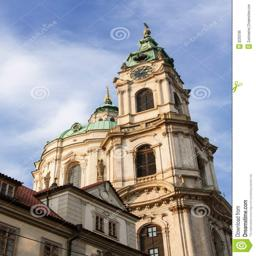

Ê®£Êú¨ 3: Expert1 È†êÊ∏¨È°ûÂà´ ancient, Expert2 È†êÊ∏¨È°ûÂà´ winding, ÁúüÂØ¶È°ûÂà• ancient
ancient_building/df7e31262b1d3ce611e6e2c2475cded5.jpg


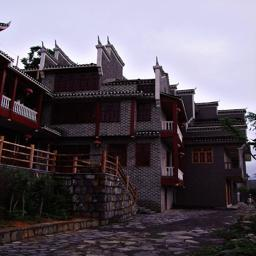

Ê®£Êú¨ 131: Expert1 È†êÊ∏¨È°ûÂà´ ancient, Expert2 È†êÊ∏¨È°ûÂà´ tall, ÁúüÂØ¶È°ûÂà• ancient
ancient_tower/ancient_tower_at_night_by_mrgo1-d30n1p0.jpg


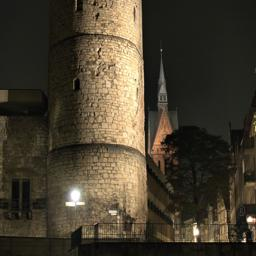

Ê®£Êú¨ 225: Expert1 È†êÊ∏¨È°ûÂà´ barren, Expert2 È†êÊ∏¨È°ûÂà´ murky, ÁúüÂØ¶È°ûÂà• barren
barren_creek/20120326_39.jpg


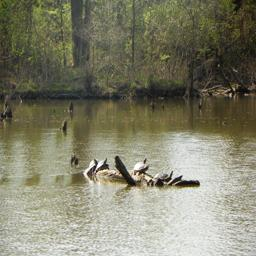

Ê®£Êú¨ 257: Expert1 È†êÊ∏¨È°ûÂà´ barren, Expert2 È†êÊ∏¨È°ûÂà´ frozen, ÁúüÂØ¶È°ûÂà• barren
barren_lake/30183615.jpg


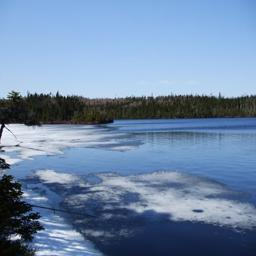

Ê®£Êú¨ 229: Expert1 È†êÊ∏¨È°ûÂà´ barren, Expert2 È†êÊ∏¨È°ûÂà´ murky, ÁúüÂØ¶È°ûÂà• barren
barren_creek/BArrenCreek59-600x440.jpg


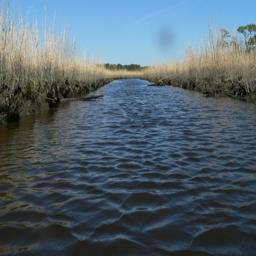

Ê®£Êú¨ 353: Expert1 È†êÊ∏¨È°ûÂà´ bent, Expert2 È†êÊ∏¨È°ûÂà´ thin, ÁúüÂØ¶È°ûÂà• bent
bent_blade/12153128084_411d5a85cb_c.jpg


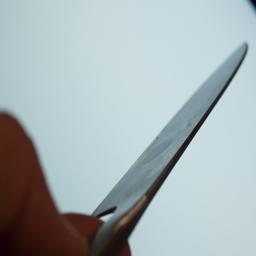

Ê®£Êú¨ 379: Expert1 È†êÊ∏¨È°ûÂà´ bent, Expert2 È†êÊ∏¨È°ûÂà´ blunt, ÁúüÂØ¶È°ûÂà• bent
bent_blade/jfmo.jpg


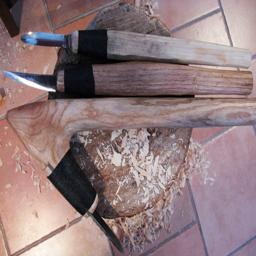

Ê®£Êú¨ 388: Expert1 È†êÊ∏¨È°ûÂà´ bent, Expert2 È†êÊ∏¨È°ûÂà´ sharp, ÁúüÂØ¶È°ûÂà• bent
bent_handle/quick-change-tweezers-with-45-degrees-bent-handle-1303-bbr.jpg


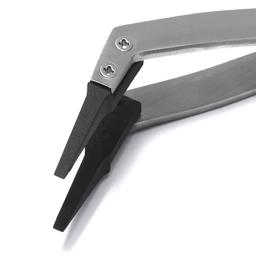

Ê®£Êú¨ 408: Expert1 È†êÊ∏¨È°ûÂà´ bright, Expert2 È†êÊ∏¨È°ûÂà´ cloudy, ÁúüÂØ¶È°ûÂà• bright
bright_lightning/2452d11967fd61afe6050a3ca9014855.jpg


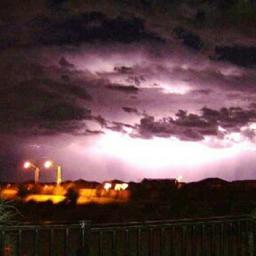

Ê®£Êú¨ 409: Expert1 È†êÊ∏¨È°ûÂà´ bright, Expert2 È†êÊ∏¨È°ûÂà´ steaming, ÁúüÂØ¶È°ûÂà• bright
bright_lightning/3608259357_0cac5bd260_z.jpg


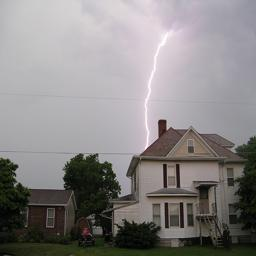

Ê®£Êú¨ 410: Expert1 È†êÊ∏¨È°ûÂà´ bright, Expert2 È†êÊ∏¨È°ûÂà´ molten, ÁúüÂØ¶È°ûÂà• bright
bright_lightning/5095816-3x2-940x627.jpg


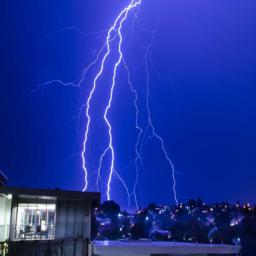

Ê®£Êú¨ 1029: Expert1 È†êÊ∏¨È°ûÂà´ brushed, Expert2 È†êÊ∏¨È°ûÂà´ dark, ÁúüÂØ¶È°ûÂà• brushed
brushed_fabric/navy-brushed-mesh-1024x768.jpg


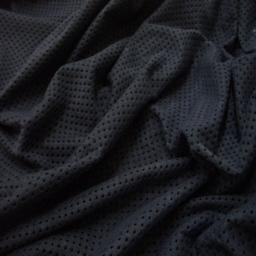

Ê®£Êú¨ 968: Expert1 È†êÊ∏¨È°ûÂà´ brushed, Expert2 È†êÊ∏¨È°ûÂà´ draped, ÁúüÂØ¶È°ûÂà• brushed
brushed_copper/original_oversize-brushed-copper-ceiling-shade.jpg


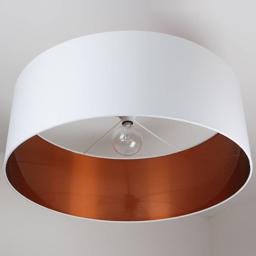

Ê®£Êú¨ 1000: Expert1 È†êÊ∏¨È°ûÂà´ brushed, Expert2 È†êÊ∏¨È°ûÂà´ sharp, ÁúüÂØ¶È°ûÂà• brushed
brushed_fabric/100_polyester_tricot_brushed_gold_velvet_fabric.jpg


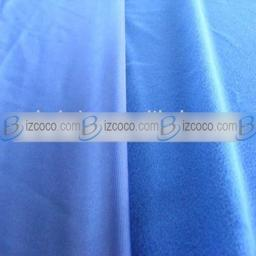

Ê®£Êú¨ 1218: Expert1 È†êÊ∏¨È°ûÂà´ burnt, Expert2 È†êÊ∏¨È°ûÂà´ dark, ÁúüÂØ¶È°ûÂà• burnt
burnt_tree/burnt-tree-dalmatian-coast-33853341.jpg


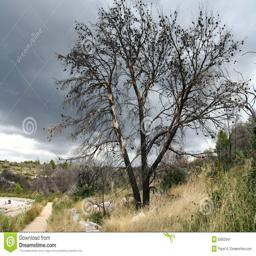

Ê®£Êú¨ 1091: Expert1 È†êÊ∏¨È°ûÂà´ burnt, Expert2 È†êÊ∏¨È°ûÂà´ eroded, ÁúüÂØ¶È°ûÂà• burnt
burnt_coal/sw-07280938-0981-BurntCoalDeposits.jpg


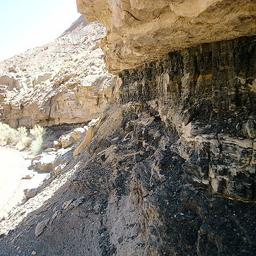

Ê®£Êú¨ 1128: Expert1 È†êÊ∏¨È°ûÂà´ burnt, Expert2 È†êÊ∏¨È°ûÂà´ caramelized, ÁúüÂØ¶È°ûÂà• burnt
burnt_oil/022.jpg


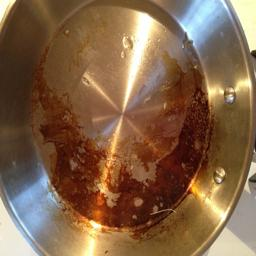

Ê®£Êú¨ 1377: Expert1 È†êÊ∏¨È°ûÂà´ caramelized, Expert2 È†êÊ∏¨È°ûÂà´ small, ÁúüÂØ¶È°ûÂà• caramelized
caramelized_tea/Blini-with-Smoked-Rainbow-Trout.jpg


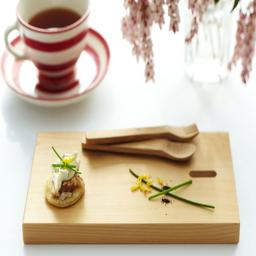

Ê®£Êú¨ 1285: Expert1 È†êÊ∏¨È°ûÂà´ caramelized, Expert2 È†êÊ∏¨È°ûÂà´ splintered, ÁúüÂØ¶È°ûÂà• caramelized
caramelized_chocolate/73426ef64c20a315926fa8fc22b5d7af.jpg


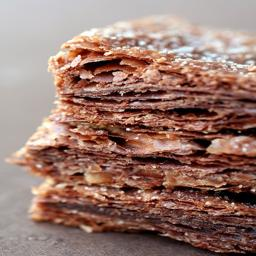

Ê®£Êú¨ 1294: Expert1 È†êÊ∏¨È°ûÂà´ caramelized, Expert2 È†êÊ∏¨È°ûÂà´ browned, ÁúüÂØ¶È°ûÂà• caramelized
caramelized_chocolate/IMG_1425-682x10241.jpg


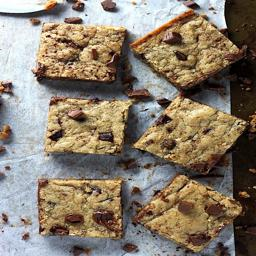

Ê®£Êú¨ 1506: Expert1 È†êÊ∏¨È°ûÂà´ clean, Expert2 È†êÊ∏¨È°ûÂà´ pureed, ÁúüÂØ¶È°ûÂà• clean
clean_room/Clean-Room-3-1024x768.jpg


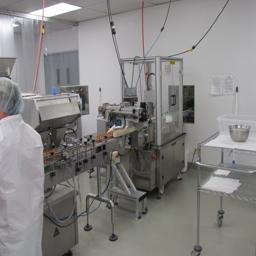

Ê®£Êú¨ 1534: Expert1 È†êÊ∏¨È°ûÂà´ clean, Expert2 È†êÊ∏¨È°ûÂà´ moldy, ÁúüÂØ¶È°ûÂà• clean
clean_room/microdisplay-clean-room-32_4.jpg


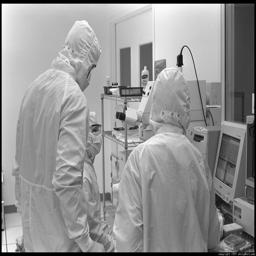

Ê®£Êú¨ 1511: Expert1 È†êÊ∏¨È°ûÂà´ clean, Expert2 È†êÊ∏¨È°ûÂà´ empty, ÁúüÂØ¶È°ûÂà• clean
clean_room/Cryopharma-Nov.-82006-006v21.jpg


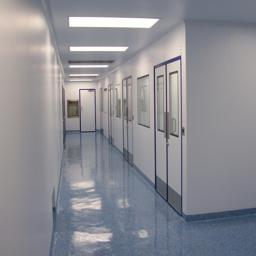

Ê®£Êú¨ 1705: Expert1 È†êÊ∏¨È°ûÂà´ cluttered, Expert2 È†êÊ∏¨È°ûÂà´ mossy, ÁúüÂØ¶È°ûÂà• cluttered
cluttered_library/page09.jpg


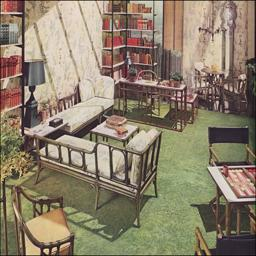

Ê®£Êú¨ 1654: Expert1 È†êÊ∏¨È°ûÂà´ cluttered, Expert2 È†êÊ∏¨È°ûÂà´ pureed, ÁúüÂØ¶È°ûÂà• cluttered
cluttered_cabinet/pkn28lazysusan.jpg


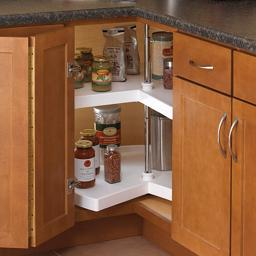

Ê®£Êú¨ 1920: Expert1 È†êÊ∏¨È°ûÂà´ coiled, Expert2 È†êÊ∏¨È°ûÂà´ eroded, ÁúüÂØ¶È°ûÂà• coiled
coiled_shell/nga_coiled_shell.jpg


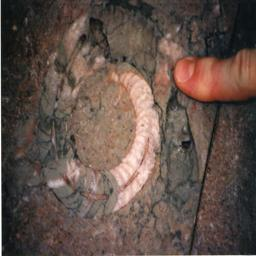

Ê®£Êú¨ 1795: Expert1 È†êÊ∏¨È°ûÂà´ coiled, Expert2 È†êÊ∏¨È°ûÂà´ curved, ÁúüÂØ¶È°ûÂà• coiled
coiled_copper/5066d7a8afca4d93471d46133627e566.jpg


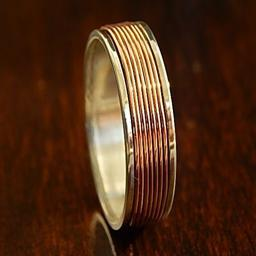

Ê®£Êú¨ 1734: Expert1 È†êÊ∏¨È°ûÂà´ coiled, Expert2 È†êÊ∏¨È°ûÂà´ mossy, ÁúüÂØ¶È°ûÂà• coiled
coiled_basket/3d2b760b46c555370f727349baa4b06d.jpg


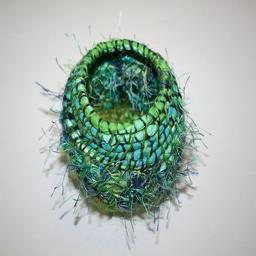

In [110]:
nub_correct_class = 10
print_nub = 3

# ÊåâÂçáÂ∫èÊéíÂ∫èÈåØË™§Áéá
error_rates = [(c, (wrong_ep1[c] + wrong_ep2[c]) / (all_attr_gt == c).sum()) for c in range(len(test_dataset.attrs))]
sorted_error_rates = sorted(error_rates, key=lambda x: x[1])

# ËæìÂá∫Ê≠£Á¢∫ÁéáËºÉÈ´òÁöÑÈ°ûÂà•
top_classes = [c for c, _ in sorted_error_rates[:nub_correct_class]]
print("Ê≠£Á¢∫ÁéáÂâç"+str(nub_correct_class) +"ÂÄãËºÉÈ´òÁöÑÈ°ûÂà´Ôºö", [test_dataset.attrs[c] for c in top_classes])

for c in top_classes:
    class_correct_ep1_correct_ep2 = set([i for i in range(len(pred_ep1)) if pred_ep1[i] == all_attr_gt[i] and pred_ep2[i] != all_attr_gt[i] and all_attr_gt[i] == c])
    class_correct_ep1_correct_ep2 = list(class_correct_ep1_correct_ep2)[:print_nub]
    for i in class_correct_ep1_correct_ep2:
        idx = i
        print(f"Ê®£Êú¨ {idx}: Expert1 È†êÊ∏¨È°ûÂà´ {test_dataset.attrs[int(pred_ep1[idx])]}, Expert2 È†êÊ∏¨È°ûÂà´ {test_dataset.attrs[int(pred_ep2[idx])]}, ÁúüÂØ¶È°ûÂà• {test_dataset.attrs[int(all_attr_gt[idx])]}")
        img_path = all_img_path[idx]
        print(img_path)
        img = Image.open(root_path+img_path)
        display(img)

### Ë®àÁÆóexpected calibration errorÁöÑReliability diagram

ÁèæÂú®ÊàëÊúâlogits_attrs_list[0]Âíålogits_attrs_list[1] ‰ªñÂÄëÂæóÁ∂≠Â∫¶ÈÉΩÊòØ(b,115)  b‰ª£Ë°®Ê∏¨Ë©¶ÂúñÁâáÁöÑbatch sizeÔºå115‰ª£Ë°®ÂÖ±Êúâ115ÂÄãÂ±¨ÊÄßÊï∏ÈáèÔºåÈÄô2ÂÄãËÆäÊï∏‰ª£Ë°®ÊØèÂºµÂúñÁâáÂ±¨ÊÄßÊ©üÁéáÔºåÁèæÂú®ÊàëÊÉ≥Ë¶ÅÂØ´pytorch Ë®àÁÆóÈÄôÂÖ©ÂÄãËÆäÊï∏ÁöÑÊØè‰∏ÄÂºµÂúñÁâáÁöÑexpected calibration errorÔºåÊàëË¶ÅÂ∞áexpected calibration errorÂàÜÂà•Áî®Âú®logits_attrs_list[0]Âíålogits_attrs_list[1] ‰∏äË®àÁÆóÔºåËº∏Âá∫‰∏¶ÂÑ≤Â≠òÈÄô2Âºµexpected calibration errorÁöÑReliability diagram „ÄÇ ÁèæÂú®ÊàëÊúâÊ∏¨Ë©¶Ê®£Êú¨ÁöÑÂØ¶ÈöõÈ°ûÂà•all_obj_gt ÔºådimÁÇ∫(b)ÔºåÊÑèÊÄùÂ∞±ÊòØÂÖ±ÊúâbÂÄãÊ∏¨Ë©¶Ê®£Êú¨ÁöÑÂØ¶ÈöõÈ°ûÂà•

In [60]:
def compute_ece(probs, targets, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0
    bin_confidences = []
    bin_accuracies = []
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (probs >= bin_lower) * (probs < bin_upper)
        prop_in_bin = in_bin.float().mean()
        if prop_in_bin.item() > 0:
            sample_indices = torch.where(torch.any(in_bin, dim=1))[0]
            bin_targets = targets[sample_indices]
            bin_probs = probs[sample_indices]
            true_prob_in_bin = (bin_targets == torch.argmax(bin_probs, dim=1)).float().mean()
            avg_confidence_in_bin = bin_probs[in_bin[sample_indices]].mean()
            ece += torch.abs(avg_confidence_in_bin - true_prob_in_bin) * prop_in_bin
            bin_confidences.append(avg_confidence_in_bin.item())
            bin_accuracies.append(true_prob_in_bin.item())
        else:
            bin_confidences.append(None)
            bin_accuracies.append(None)

    return ece, bin_confidences, bin_accuracies

# logits_attrs_list = [logits_attrs_list[0], logits_attrs_list[1]]
logits_attrs_list = [all_logits.float(), logits_attrs_list[1]]
probs_list = [F.softmax(logits, dim=1) for logits in logits_attrs_list]



In [58]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
def plot_dot_reliability_diagram(ece_value, bin_confidences, bin_accuracies, model_index,test_dataset):
    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect calibration")
    plt.scatter(bin_confidences, bin_accuracies, marker='o', color='blue', label="Model {}".format(model_index + 1))
    plt.xlabel("Confidence", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.title("Reliability Diagram for Model {} (ECE={:.4f})".format(model_index + 1, ece_value.item()), fontsize=16)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xticks(np.arange(0, 1.1, 0.1), fontsize=12)
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12)
    plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    plt.gca().set_axisbelow(True)
    plt.legend(fontsize=12)
    plt.tight_layout()
    Path('plt/'+str(len(test_dataset.pairs))).mkdir(parents=True, exist_ok=True)
    plt.savefig('plt/'+str(len(test_dataset.pairs))+'/'+test_dataset.phase+'_'+"dot_reliability_diagram_model_{}.png".format(model_index + 1))

In [ ]:
probs = F.softmax(logits_attrs_list[1], dim=1)
ece_and_bin_values = [compute_ece(probs, all_attr_gt)]
for i, (ece_value, bin_confidences, bin_accuracies) in enumerate(ece_and_bin_values):
    plot_dot_reliability_diagram(ece_value, bin_confidences, bin_accuracies, 1,test_dataset)
probs = F.softmax(all_logits.float(), dim=1)
ece_and_bin_values = [compute_ece(probs, all_pair_gt)]
for i, (ece_value, bin_confidences, bin_accuracies) in enumerate(ece_and_bin_values):
    plot_dot_reliability_diagram(ece_value, bin_confidences, bin_accuracies, 0,test_dataset)

### Áπ™Ë£ΩÊ∑∑Ê∑ÜÁü©Èô£

In [38]:
cm_expert1

array([[75,  1,  0, ...,  0,  0,  0],
       [ 0, 14,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [51]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
pred_ep1

In [ ]:
# ÁªòÂà∂Ê∑∑Ê∑ÜÁü©ÈòµÁöÑÂáΩÊï∞
def plot_confusion_matrix(cm, test_dataset,title,):
    plt.figure(figsize=(50, 50))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.colorbar()
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Ê∑ªÂä†ÊñáÊú¨Ê≥®Èáä
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
    plt.savefig('plt/'+str(len(test_dataset.pairs))+'/'+test_dataset.phase+'_'+ title + '.png')
    plt.show()
b,n_attr =  logits_attrs_list[1].size()
cm_expert1 = confusion_matrix(all_attr_gt.numpy(), pred_ep1.numpy(), labels=np.arange(n_attr))
cm_expert2 = confusion_matrix(all_attr_gt.numpy(), pred_ep2.numpy(), labels=np.arange(n_attr))

# ËÆ°ÁÆóÊ∑∑Ê∑ÜÁü©Èòµ
cm_expert1 = confusion_matrix(all_attr_gt, pred_ep1, labels=np.arange(n_attr))
# ÁªòÂà∂ expert1 ÁöÑÊ∑∑Ê∑ÜÁü©Èòµ
plot_confusion_matrix(cm_expert1,test_dataset ,'Confusion Matrix of Expert1')
# ÁªòÂà∂ expert2 ÁöÑÊ∑∑Ê∑ÜÁü©Èòµ
plot_confusion_matrix(cm_expert2,test_dataset ,'Confusion Matrix of Expert2')

In [66]:
'plt/'+str(len(test_dataset.pairs))+'/'+test_dataset.phase+'_confusion_matrix.png'

'plt/28175/test_confusion_matrix.png'

In [ ]:
all_fv_proj_idx = []
for i in range(245):
    fv_proj_idx = 0
    fv_proj_idx = torch.Tensor().cuda()
    for obj_idx in range(len(pairs)):
        if pairs[obj_idx][1] ==i:
            fv_proj_idx = torch.cat([fv_proj_idx, pairs[obj_idx]], dim=0)
    fv_proj_idx=fv_proj_idx.reshape(-1,2)
    all_fv_proj_idx.append(fv_proj_idx) 


### Ê™¢Êü•‰∏Ä‰∏ãÈåØË™§

In [ ]:
for idx in all_fv_proj_idx:
    a,_=idx.size()
    assert a!=0

### Áç≤Âæóft Âíåbatch_obj_idx    ft(1962,768)  batch_obj_idx int

In [28]:
idx_text_features = predict[4]
batch_obj_idx=data[2][0]

### Ë®àÁÆófs|o

In [ ]:
# batch_obj_idx = 0

In [ ]:
fv_proj = 0
fv_proj = torch.Tensor().cuda()
for proj_idx in all_fv_proj_idx[batch_obj_idx]:
    #print(proj_idx)
    index = torch.nonzero(torch.eq(pairs, proj_idx).all(dim=1))
    fv_proj = torch.cat([fv_proj, idx_text_features[index[0]]], dim=0)

In [ ]:
fv_proj.size()

###  Ë®àÁÆófs|oÂú®DFSP‰∏≠

In [ ]:
# batch_obj_idx=obj_idx[0]
# fv_proj = 0
# fv_proj = torch.Tensor().cuda()
# for proj_idx in all_fv_proj_idx[batch_obj_idx]:
#     #print(proj_idx)
#     index = torch.nonzero(torch.eq(pairs, proj_idx).all(dim=1))
#     fv_proj = torch.cat([fv_proj, idx_text_features[index[0]]], dim=0)

### ÂàÜËß£ft>fs,fo

In [28]:
# text_feature=predict[4]
text_feature= torch.rand(1962, 768)  ###ÂÖàÁî®‰∫ÇÊï∏ÁÆó

In [29]:
l, c = text_feature.shape
att_idx, obj_idx = pairs[:, 0].cpu().numpy(), pairs[:, 1].cpu().numpy()
text_att = torch.zeros(115, c).cuda()
text_obj = torch.zeros(245, c).cuda()
for i in range(115):
    text_att[ i, :] = text_feature[ np.where(att_idx==i)[0], :].mean(-2)
for i in range(245):
    text_obj[ i, :] = text_feature[ np.where(obj_idx==i)[0], :].mean(-2)    
text_decom_feature = torch.cat([text_att, text_obj], dim=0)

In [30]:
fs = text_decom_feature[:115, :]

In [31]:
fo = text_decom_feature[115:, :]

### Âú®dfsp ‰∏≠ Áç≤Âæóft+>fofs

In [32]:
# ft=fusion.decompose_ftfsfo(idx_text_features,idx)
# fo = text_decom_feature[115:, :]
# fs = text_decom_feature[:115, :]

In [33]:
f_v,_ =DFSP_model.visual(batch_img.type(DFSP_model.clip.dtype))   ## bs * 768
# f_s_given_o = fv_proj
f_s_given_o = torch.rand(10, 768).cuda() ###ÂÖàÁî®‰∫ÇÊï∏ÁÆó

In [34]:
f_v.size()

torch.Size([16, 768])

### Êõ¥ÊîπtestÈÄüÂ∫¶

In [17]:
def cal_proj_f_v_to_s_given_o(f_v,f_s_given_o):
    # Ë®àÁÆó f_s_given_o ÁöÑËΩâÁΩÆ‰πò‰ª• f_s_given_oÔºåÂÜçÂèñÂÖ∂ÂèçÁü©Èô£
    temp = torch.matmul(f_s_given_o, f_s_given_o.t()).inverse()
    #ÊúÄÂæåËàá ùëì(ùë†|ùëú)(ùëì_(ùë†|ùëú)^ùëá ùëì_(ùë†|ùëú))„Äó^(‚àí1)ùëì(ùë†|ùëú)^T
    temp1 = torch.matmul(f_s_given_o.t(),temp)
    temp2 =torch.matmul(temp1,f_s_given_o)
    # Ë®àÁÆó f_v Ëàá‰∏äËø∞ÁµêÊûúÁöÑ‰πòÁ©çÔºåÂç≥ÂèØÂæóÂà∞ f_v->s|o ÁöÑËΩâÁΩÆ
    f_v_to_s_given_o_t = torch.matmul(temp2, f_v.t().float())
    # ËΩâÁΩÆÂõû‰æÜÂç≥ÁÇ∫ f_v->s|o
    f_v_to_s_given_o = f_v_to_s_given_o_t.t()
    return f_v_to_s_given_o

In [58]:
gt_obj_idx = data[2]
idx_text_features = torch.rand(1962, 768).cuda()
idx = pairs
f_s_given_o = 0
f_s_given_o = torch.Tensor().cuda()
normalized_img = torch.rand(16, 768).cuda()


In [76]:
proj_f_v_to_s_given_o_finally = torch.Tensor().cuda()
for gt_obj,batch_idx in zip(gt_obj_idx,range(len(gt_obj_idx))):  
    f_s_given_o = torch.Tensor().cuda()
    for proj_idx in all_fv_proj_idx[gt_obj]:       ##ÂÅáË®≠ÊØèÂÄãbatchÁöÑobjÈÉΩ‰∏ÄÊ®£ gt_obj_idx ÂÇ≥ÂÖ•ÂÄºÊòØdata[2][0]
        index = torch.nonzero(torch.eq(idx, proj_idx).all(dim=1))         
        f_s_given_o = torch.cat([f_s_given_o, idx_text_features[index[0]]], dim=0)   ###Áç≤Âæófv_proj s|o
#     print(f_s_given_o.size())
#     print(normalized_img[batch_idx].size())
    proj_f_v_to_s_given_o = normalized_img[batch_idx]
    #proj_f_v_to_s_given_o = cal_proj_f_v_to_s_given_o(normalized_img[batch_idx],f_s_given_o)  
    ###Á¨¨ batch_idxÂÄãÂúñÁâáËàáf_s_given_oÈÄ≤Ë°åË®àÁÆó ÔºåÁç≤Âæóproj_f_v_to_s_given_oÂæå concatËµ∑‰æÜ
    ### fv dim(b,768) f(ùë†|ùëú)  dim(?,768)>f(v‚Üís|o)^T dim(b,768)
    proj_f_v_to_s_given_o_finally = torch.cat([proj_f_v_to_s_given_o_finally, proj_f_v_to_s_given_o.unsqueeze(0)] , dim=0)
proj_f_v_to_s_given_o_finally_norm=proj_f_v_to_s_given_o_finally / proj_f_v_to_s_given_o_finally.norm(dim=-1, keepdim=True)

In [72]:
proj_f_v_to_s_given_o_finally_norm.size()

torch.Size([16, 768])

In [70]:
proj_f_v_to_s_given_o_finally.size()

torch.Size([16, 768])

In [78]:
proj_f_v_to_s_given_o_finally_norm.size()

torch.Size([16, 768])

In [77]:
f_s_given_o.size()

torch.Size([9, 768])

In [50]:
proj_f_v_to_s_given_o = cal_proj_f_v_to_s_given_o(f_v,f_s_given_o)

torch.Size([10, 10])
torch.Size([768, 10])
torch.Size([768, 768])
torch.Size([768, 16])


In [45]:
proj_f_v_to_s_given_o.size()

torch.Size([16, 768])

In [ ]:
proj_f_v_to_s_given_o_norm=proj_f_v_to_s_given_o / proj_f_v_to_s_given_o.norm(dim=-1, keepdim=True)

In [20]:
i= 0
with torch.no_grad():
    for idx, data in tqdm(
        enumerate(dataloader), total=len(dataloader), desc="Testing"
    ):
        batch_img = data[0].cuda()
#         predict = DFSP_model(batch_img, pairs,True,data[2].cuda())
        predict = DFSP_model(batch_img, pairs,True,data[2][0],all_fv_proj_idx=all_fv_proj_idx)
        break

Testing:   0%|          | 0/1897 [00:06<?, ?it/s]


In [17]:
i= 0
with torch.no_grad():
    for idx, data in tqdm(
        enumerate(dataloader), total=len(dataloader), desc="Testing"
    ):
        batch_img = data[0].cuda()
        predict = DFSP_model(batch_img, pairs)
        i = i+1
        if i ==2:
            break

Testing:   0%|          | 1/843 [00:07<1:49:19,  7.79s/it]


In [257]:
print(data[1])
print(data[2])
print(data[3])

tensor([0])
tensor([35])
tensor([0])


In [165]:
batch_img = data[0].cuda()
predict_org = DFSP_model(batch_img, pairs)


In [166]:
predict_org[0].size()

torch.Size([128, 1962])

In [167]:
logits_att, logits_obj=DFSP_model.decompose_logits(predict_org[0],pairs)

In [168]:
logits_att.size()

torch.Size([128, 115])

In [169]:
b,_= logits_att.size()

In [170]:
logits_combined = torch.zeros(b,len(pairs))

In [175]:
for i in range(len(pairs)):
    att_idx, obj_idx = pairs[i]
    logits_combined[:, i] = (logits_att[:, att_idx] + logits_obj[:, obj_idx]) 

In [176]:
logits_combined.size()

torch.Size([128, 1962])

In [177]:
logits_combined[0]

tensor([22.3828, 21.7969, 21.3438,  ..., 18.1484, 17.3750, 16.4062],
       grad_fn=<SelectBackward0>)

In [154]:
logits_combined.size()

torch.Size([16, 1962])

In [ ]:
import torch 
from torch.nn import CosineSimilarity


cos_sim = CosineSimilarity(dim=0) 
for i in range(128):
    output= cos_sim(logits_attrs_list[0][i], logits_attrs_list[1][i])
    print(output)
